<h1> DSCI 100 Project <\h1>

*Predicting news article popularity*
Group 28: Natsumi Tadakuma, Jackie Huang, Cindy Chen, Nikko Dumrique

### Introduction
In this proposal, we aim to predict the popularity based on News Popularity Data Set from https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity. The dataset summarizes statistical features about articles published on Mashable in a period of two years. Although the data set’s primary concern is predicting popularity, there is no inherent categorical variable to measure it. Therefore, for our analysis we will define the popularity of a news article based on the number of shares it has. We have created 4 categories of which define a range of shares; Not popular, somewhat popular, popular, and viral. 

#### Preliminary Exploratory data analysis

Predictive Question: Can we predict the popularity (# number of shares) given ... (predictor of the data)

In [42]:
library(tidyr)
library(repr)
library(rsample)
library(GGally)
library(ggplot2)
library(tidyverse)

The data we are trying to extract is in zip format. To extract the actual csv file from the web, we need to create a temporary file for the zip file, then unzip the file locally to read. On top of this, since the zip file also contains a .names file, we need to specify what we want to read when doing read_csv.

In [2]:
#download the zip file into a temporary file
temp <- tempfile()
temp_dir <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip", temp, mode="wb")
OnlineNewsPopularity_unzipped <- unzip(temp, exdir = temp_dir)

#read the csv within the unzipped_contents
news <- OnlineNewsPopularity_unzipped[2] %>% #may be unzipped_contents[1] if you get an error
    read_csv()
head(news)
unlink(c(temp, temp_dir))

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5000000,-0.1875000,0.00000000,0.1875000,593
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0000000,0.0000000,0.50000000,0.0000000,711
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0000000,0.0000000,0.50000000,0.0000000,1500
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731,9,531,0.5037879,1,0.6656347,9,0,1,⋯,0.13636364,0.8,-0.3696970,-0.600,-0.1666667,0.0000000,0.0000000,0.50000000,0.0000000,1200
http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.4156456,1,0.5408895,19,19,20,⋯,0.03333333,1.0,-0.2201923,-0.500,-0.0500000,0.4545455,0.1363636,0.04545455,0.1363636,505
http://mashable.com/2013/01/07/beewi-smart-toys/,731,10,370,0.5598886,1,0.6981982,2,2,0,⋯,0.13636364,0.6,-0.1950000,-0.400,-0.1000000,0.6428571,0.2142857,0.14285714,0.2142857,855


## Wrangle and clean
Creating a categorical variable to represent the popularity (shares) so it help us better visualize the data. The dividing criteria comes from the summary of the shares

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     933    1400    2935    2600  690400 

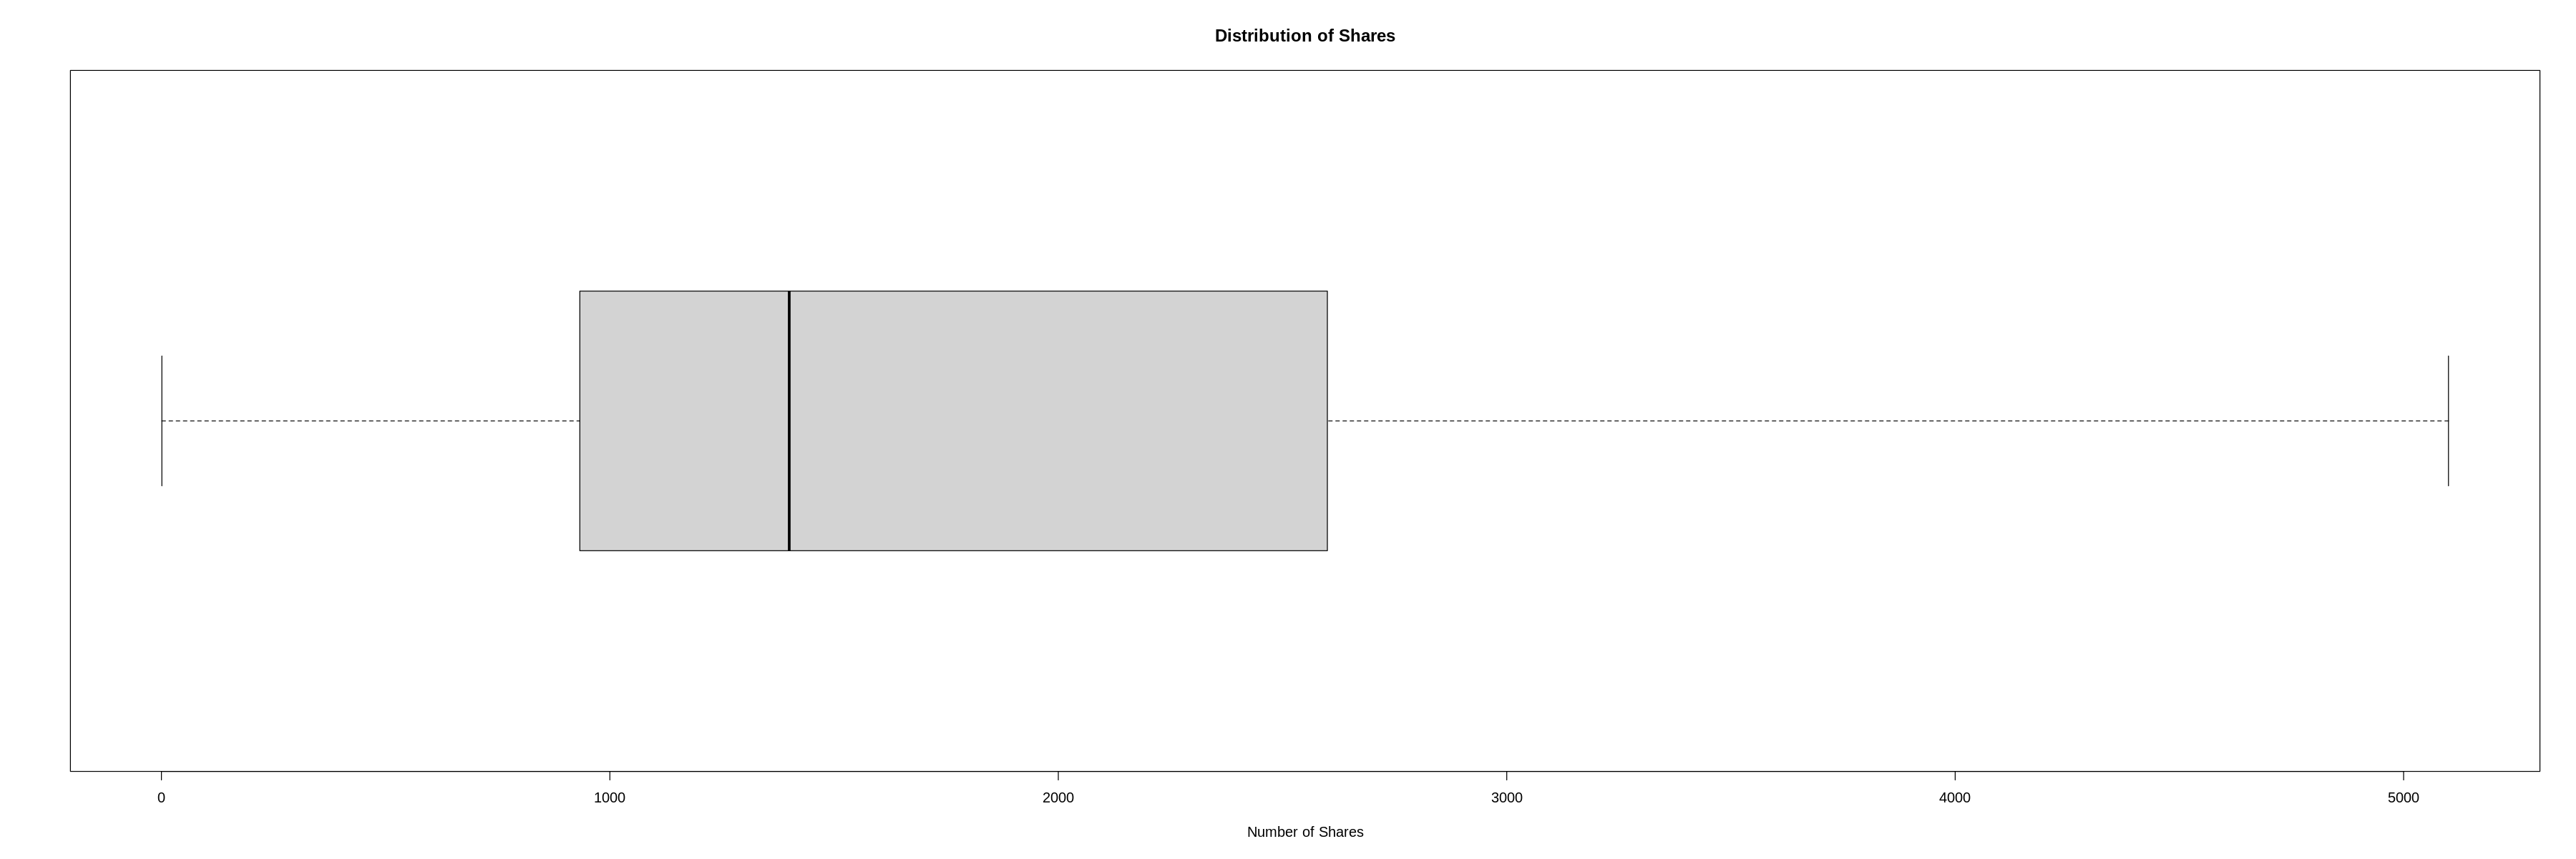

In [44]:
options(repr.plot.width = 30, repr.plot.height = 10)
summary(news$shares)
boxplot(news$shares, outline = FALSE, horizontal = TRUE)
title(main = "Distribution of Shares", xlab = "Number of Shares")

summary on the number of shares:

In [4]:
news = news %>% 
      mutate(popularity = ifelse(shares < 500, "Not_Popular",
                          ifelse(shares %in% 500:1399, "Somewhat_Popular",
                          ifelse(shares %in% 1400:3299, "Popular", "Viral")))) %>% 
      mutate(popularity = as.factor(popularity))

In [5]:
# combining the weekdays and data channels into one column
# We set all 0 to NA here, because in the original data set, 0 is used to represent FALSE. 
# Therefore, to get rid of all FALSE values, we set them to NA so that in pivot_longer, 
# we can remove these unecessary data points using value_drop_na = TRUE
news[,14:19][news[,14:19] == 0] = NA
news = news %>% 
    pivot_longer(data_channel_is_lifestyle:data_channel_is_world,
                 names_to = "Channel",
                 names_prefix = "data_channel_is_",
                 values_to = "Value",
                 values_drop_na = TRUE) %>% 
  select(-Value)
# Same thing here, setting 0 values to NA to get rid of them
news[,32:38][news[32:38] == 0] = NA
news = news %>% 
    pivot_longer(weekday_is_monday:weekday_is_sunday,
                 names_to = "weekday",
                 names_prefix = "weekday_is_",
                 values_to = "value",
                 values_drop_na = TRUE) %>% 
  select(-value)
head(news$weekday, 21)

[1] "monday"    "tuesday"   "wednesday" "thursday"  "friday"    "saturday" 
 [7] "monday"    "tuesday"   "wednesday" "thursday"  "friday"    "saturday" 
[13] "monday"    "tuesday"   "wednesday" "thursday"  "friday"    "saturday" 
[19] "monday"    "tuesday"   "wednesday"

### Exploratory Data analysis

By ref

In [6]:
splitted_data <- initial_split(news, prop = 0.80, strata = popularity)  
training_set <- training(splitted_data)   
testing_set <- testing(splitted_data)
# training_set
# testing_set
# https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

In [7]:
## To filter out only quantitative varibles
news_numerical = unlist(lapply(training_set, is.numeric)) 
news_numerical = training_set[ , news_numerical]
cor(news_numerical) %>%
  as_data_frame(rownames = "var1") %>%
    pivot_longer(cols = -var1, names_to = "var2", values_to = "coeff") %>%
    filter(var1 == "shares") %>% 
    filter(var1 != var2) %>%
    arrange(desc(abs(coeff)))
## Code reference:
## https://stackoverflow.com/questions/48123611/using-ggpairs-on-a-large-dataset-with-many-variables

Warning message:
“`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


var1,var2,coeff
<chr>,<chr>,<dbl>
shares,kw_avg_avg,0.098262603
shares,self_reference_avg_sharess,0.065743749
shares,kw_max_avg,0.064773487
shares,self_reference_min_shares,0.063915905
shares,self_reference_max_shares,0.051195109
shares,kw_max_min,0.043574167
shares,kw_avg_min,0.043330966
shares,num_hrefs,0.041896338
shares,global_subjectivity,0.033497927


Based on the above, we choose kw_avg_avg, self_reference_avg_sharess, and num_hrefs.
That is, the Average keyword (avg. shares), the Avg. shares of referenced articles in Mashable, and the Number of links as they have the highest correlation with shares.



By filtering out the missing values, we successfully increased the correlation for 0.001 for the self_reference_avg_sharess predictor. That is evidence of something worked

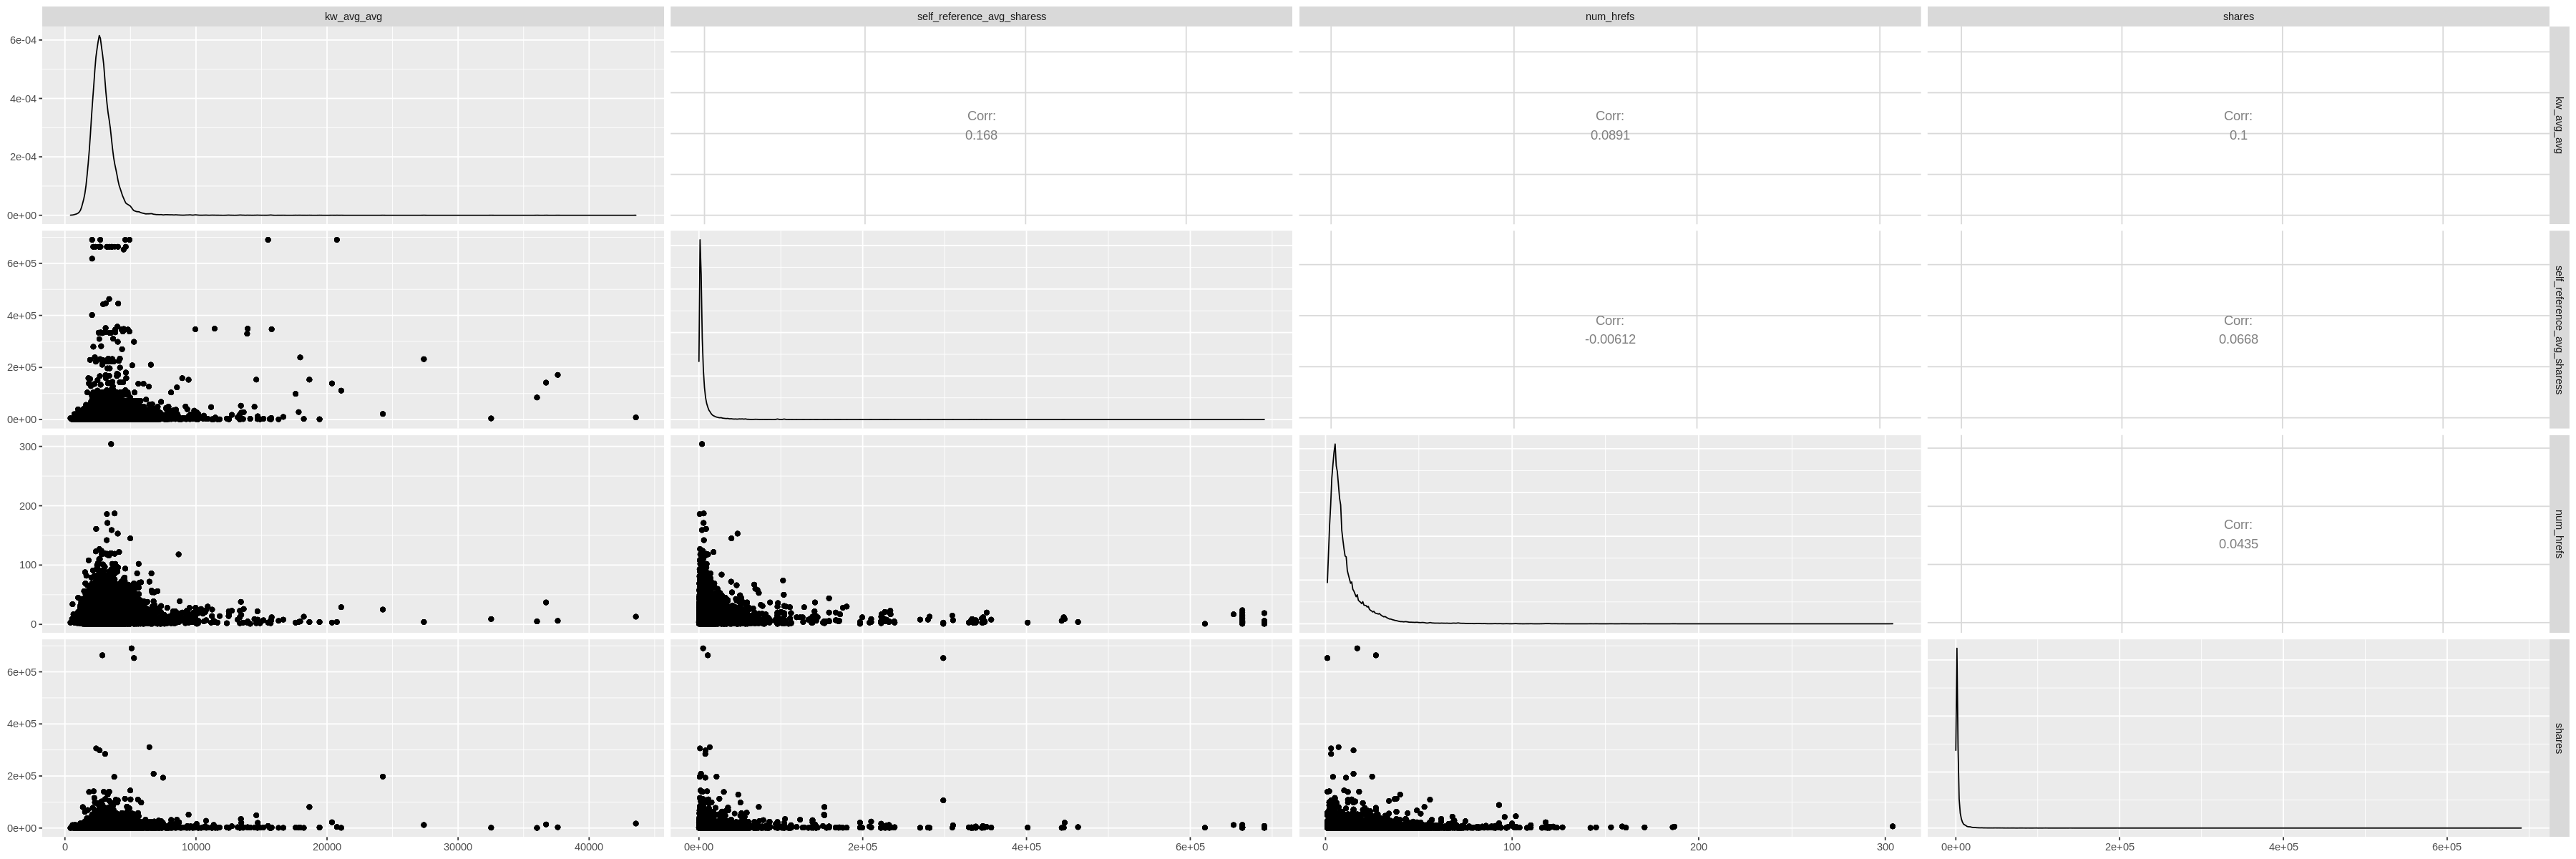

In [8]:
training_set %>% select(kw_avg_avg, self_reference_avg_sharess, num_hrefs, shares) %>% 
                  filter(kw_avg_avg != 0) %>% 
                  filter(self_reference_avg_sharess != 0) %>% 
                  filter(num_hrefs != 0) %>% 
                   ggpairs()

In [9]:
tran_predictors = training_set %>% select(kw_avg_avg, self_reference_avg_sharess, 
                                          num_hrefs, shares, popularity)
tran_predictors

kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares,popularity
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,496.000,4,593,Somewhat_Popular
0,496.000,4,593,Somewhat_Popular
0,496.000,4,593,Somewhat_Popular
0,496.000,4,593,Somewhat_Popular
0,496.000,4,593,Somewhat_Popular
0,0.000,3,711,Somewhat_Popular
0,0.000,3,711,Somewhat_Popular
0,0.000,3,711,Somewhat_Popular
0,0.000,3,711,Somewhat_Popular


Observing the dataset, we notice that some obervations have 0 as an value, we treat them as missing values as 0 will not do any good to our predictions. So we further process our training data

   kw_avg_avg    self_reference_avg_sharess   num_hrefs          shares      
 Min.   :    0   Min.   :     0             Min.   :  0.00   Min.   :     1  
 1st Qu.: 2314   1st Qu.:   959             1st Qu.:  4.00   1st Qu.:   934  
 Median : 2737   Median :  2100             Median :  7.00   Median :  1400  
 Mean   : 2892   Mean   :  5826             Mean   : 10.41   Mean   :  2946  
 3rd Qu.: 3274   3rd Qu.:  4650             3rd Qu.: 13.00   3rd Qu.:  2600  
 Max.   :43568   Max.   :690400             Max.   :304.00   Max.   :690400  

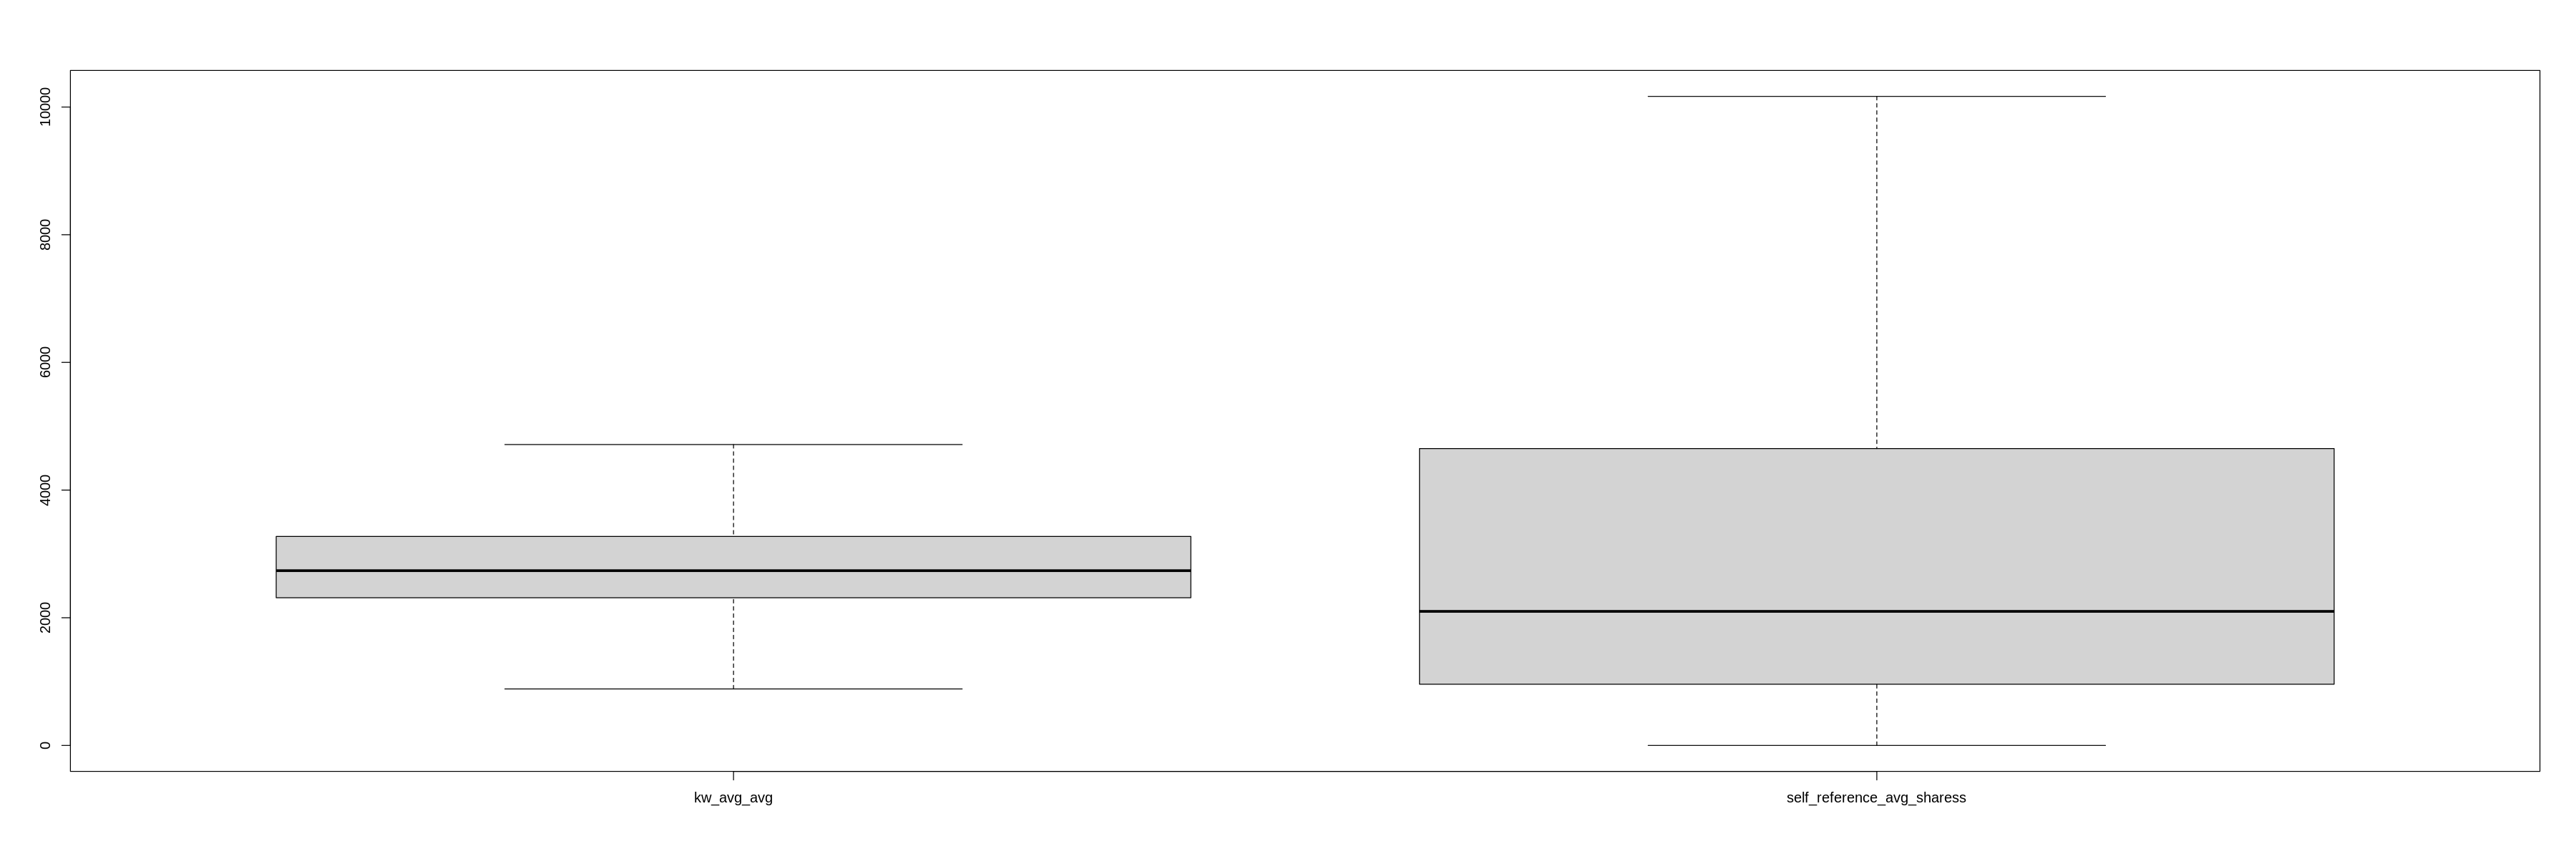

In [12]:
summary(tran_predictors %>% select(-popularity))
boxplot(tran_predictors %>% select(-popularity, -shares, -num_hrefs), outline = FALSE)

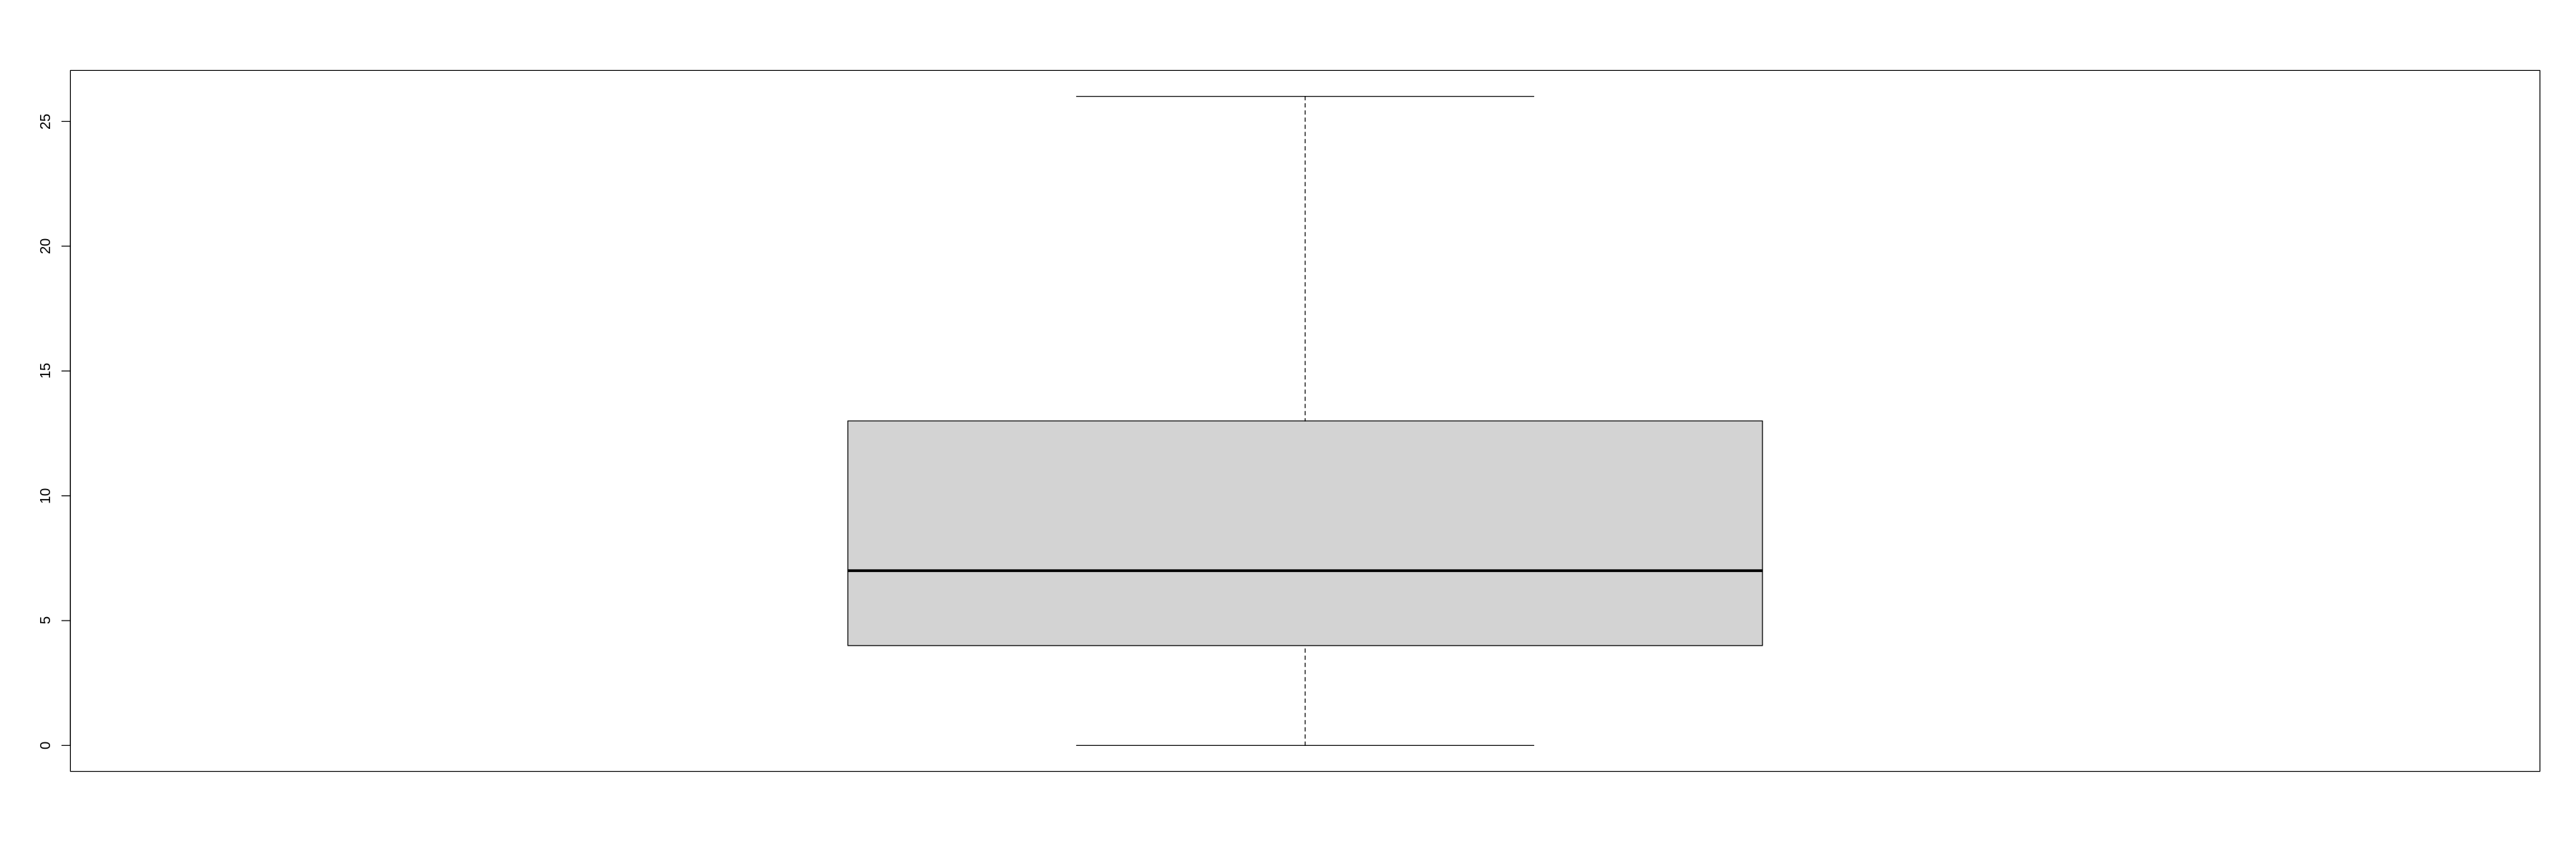

In [13]:
boxplot(tran_predictors$num_hrefs, outline = FALSE)

In [14]:
tran_predictors = tran_predictors %>% 
                  filter(kw_avg_avg != 0) %>% 
                  filter(self_reference_avg_sharess != 0) %>% 
                  filter(num_hrefs != 0)
tran_predictors

kw_avg_avg,self_reference_avg_sharess,num_hrefs,shares,popularity
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
804.3803,3100.000,5,755,Somewhat_Popular
804.3803,3100.000,5,755,Somewhat_Popular
804.3803,3100.000,5,755,Somewhat_Popular
804.3803,3100.000,5,755,Somewhat_Popular
1184.5600,727.000,4,4600,Viral
1184.5600,727.000,4,4600,Viral
1184.5600,727.000,4,4600,Viral
1184.5600,727.000,4,4600,Viral
1184.5600,727.000,4,4600,Viral


##### Visualize Explorary

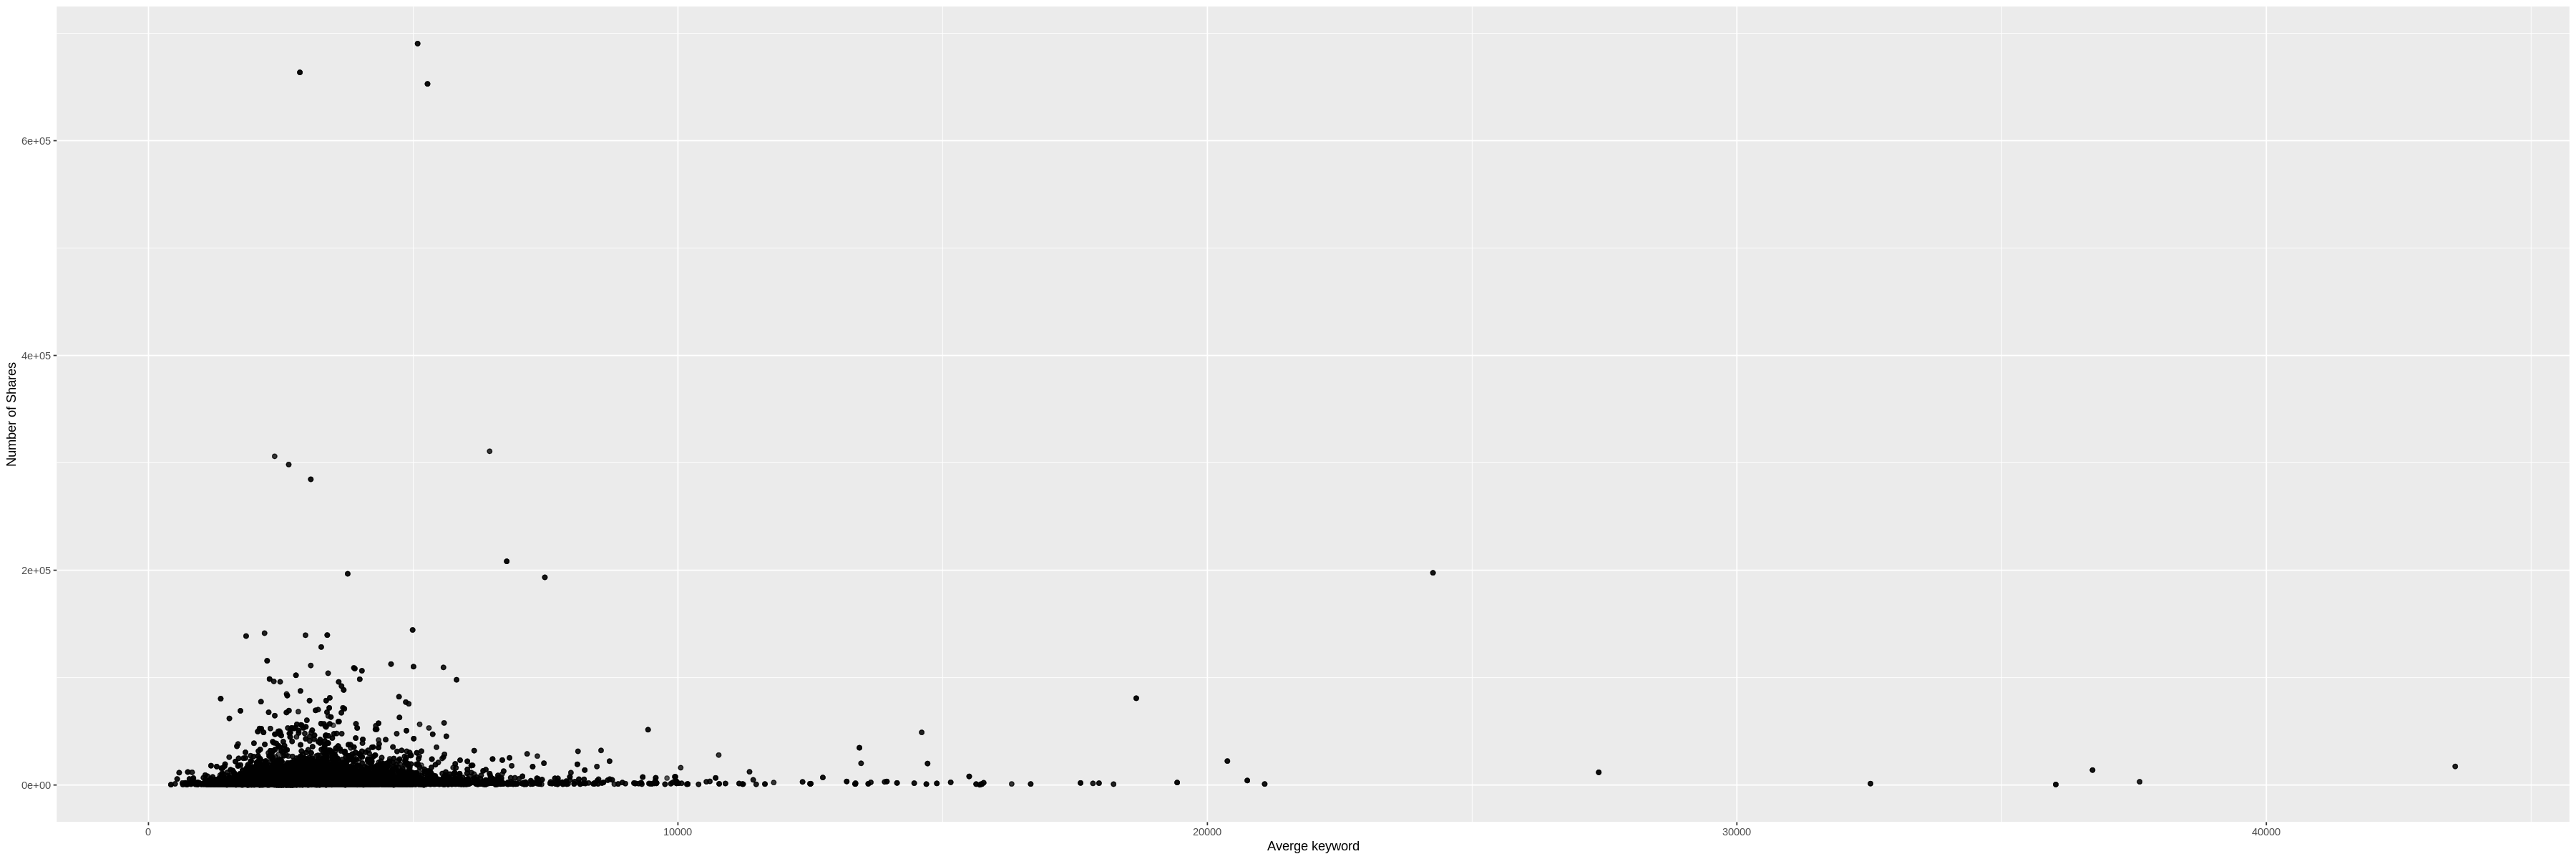

In [17]:
eda_kw_rm <- tran_predictors %>% 
                  ggplot(aes(x = kw_avg_avg, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Averge keyword") +
                  ylab("Number of Shares")
eda_kw_rm

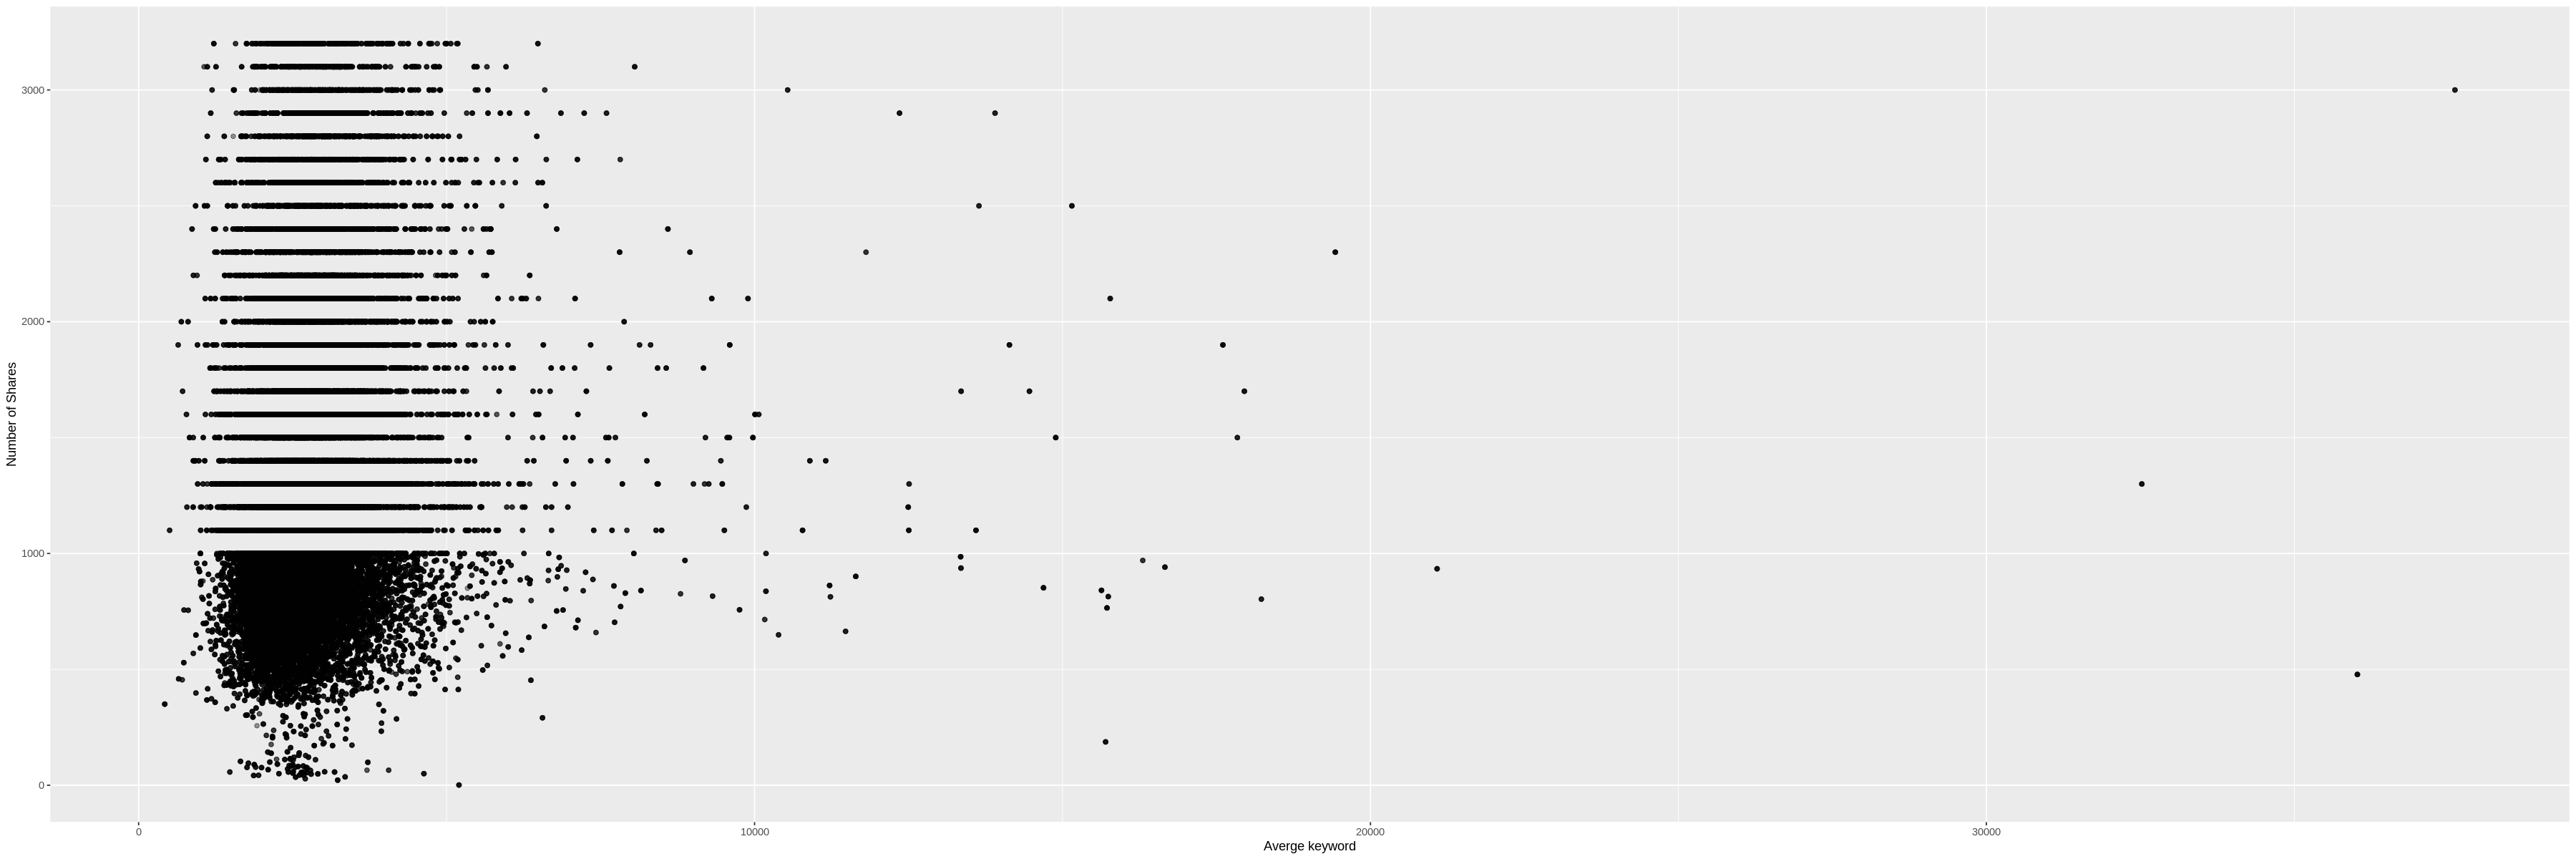

In [18]:
eda_kw_rm_outl <- tran_predictors %>% 
                  filter(popularity != "Viral") %>% 
                  # filter(kw_avg_avg < 10000) %>% 
                  ggplot(aes(x = kw_avg_avg, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Averge keyword") +
                  ylab("Number of Shares")
eda_kw_rm_outl

 the correlation is small, so it is unlikely we will see a linear pattern

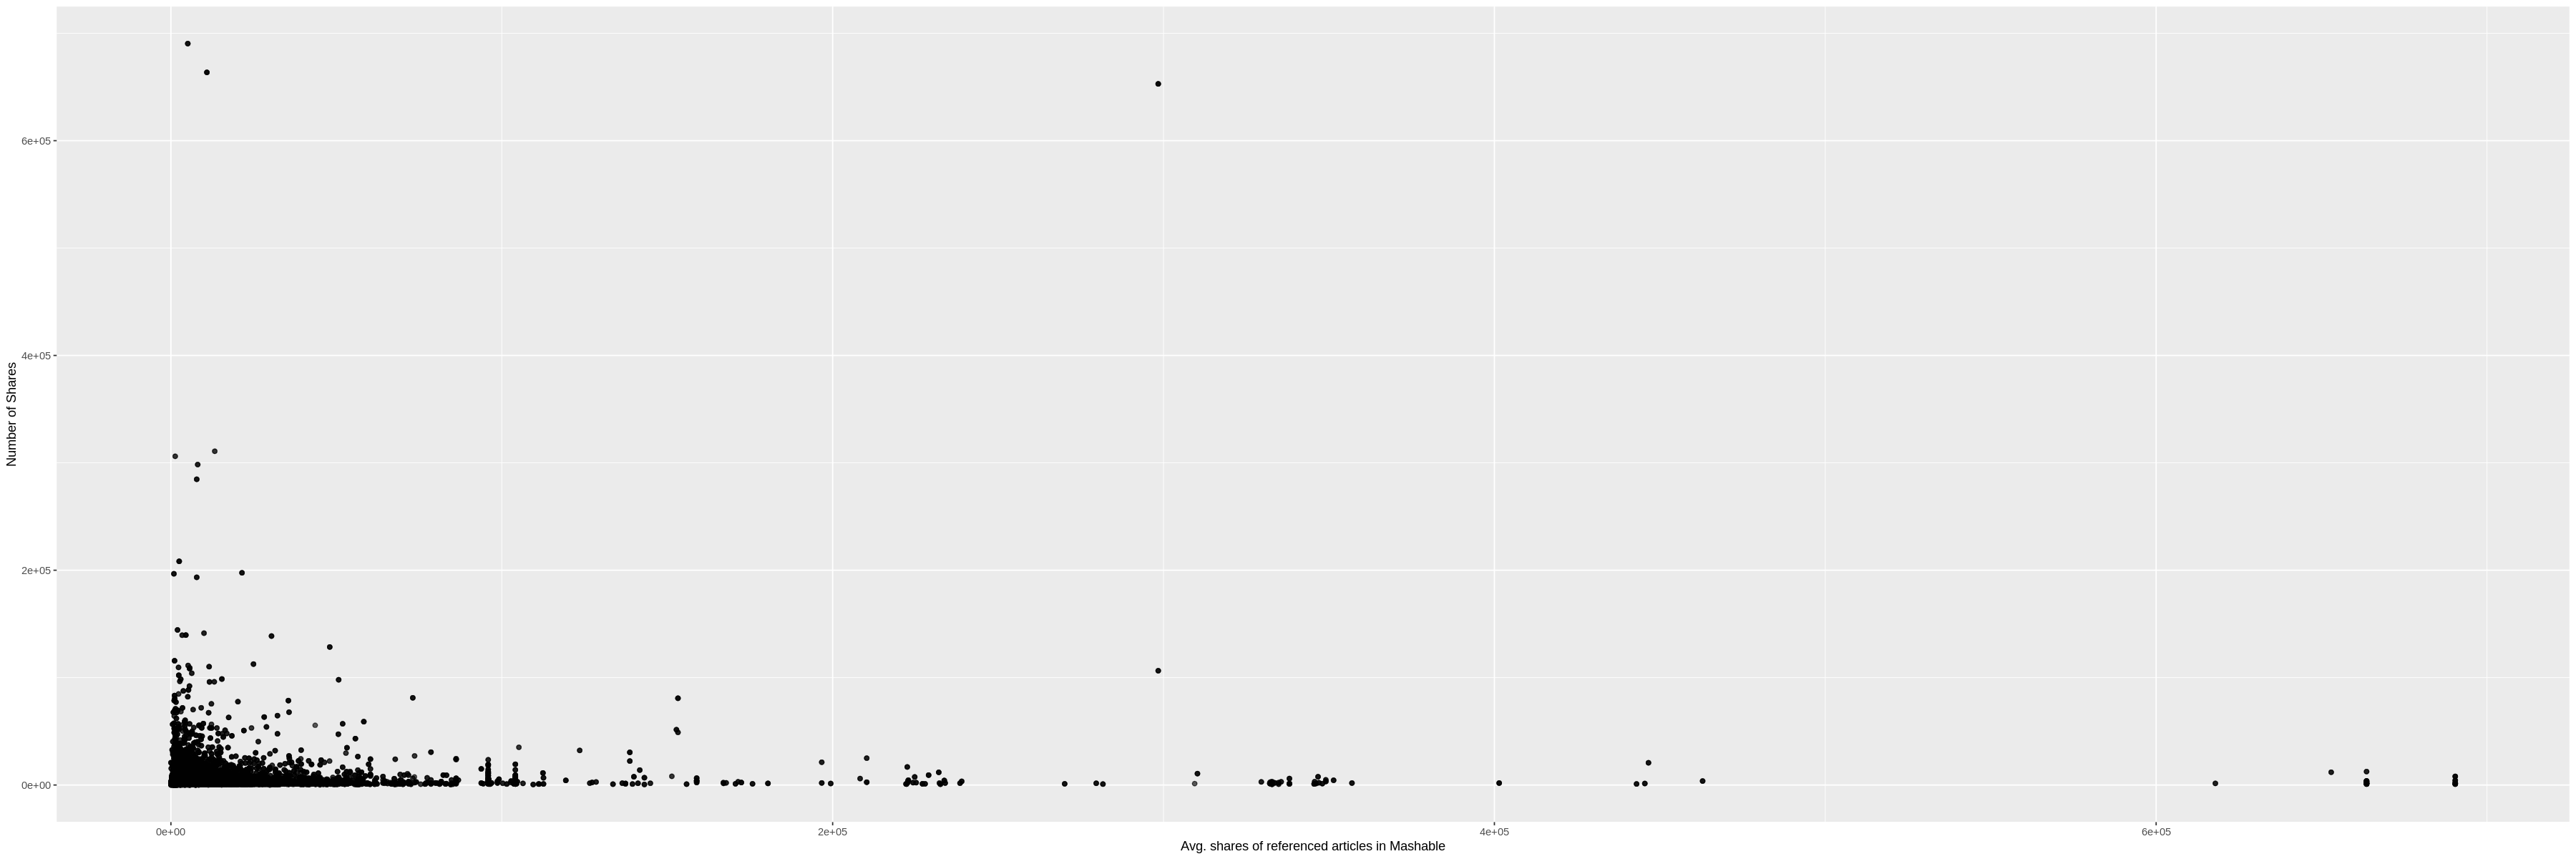

In [22]:
eda_sf_rm <- tran_predictors %>% 
                  ggplot(aes(x = self_reference_avg_sharess, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Avg. shares of referenced articles in Mashable") +
                  ylab("Number of Shares")
eda_sf_rm

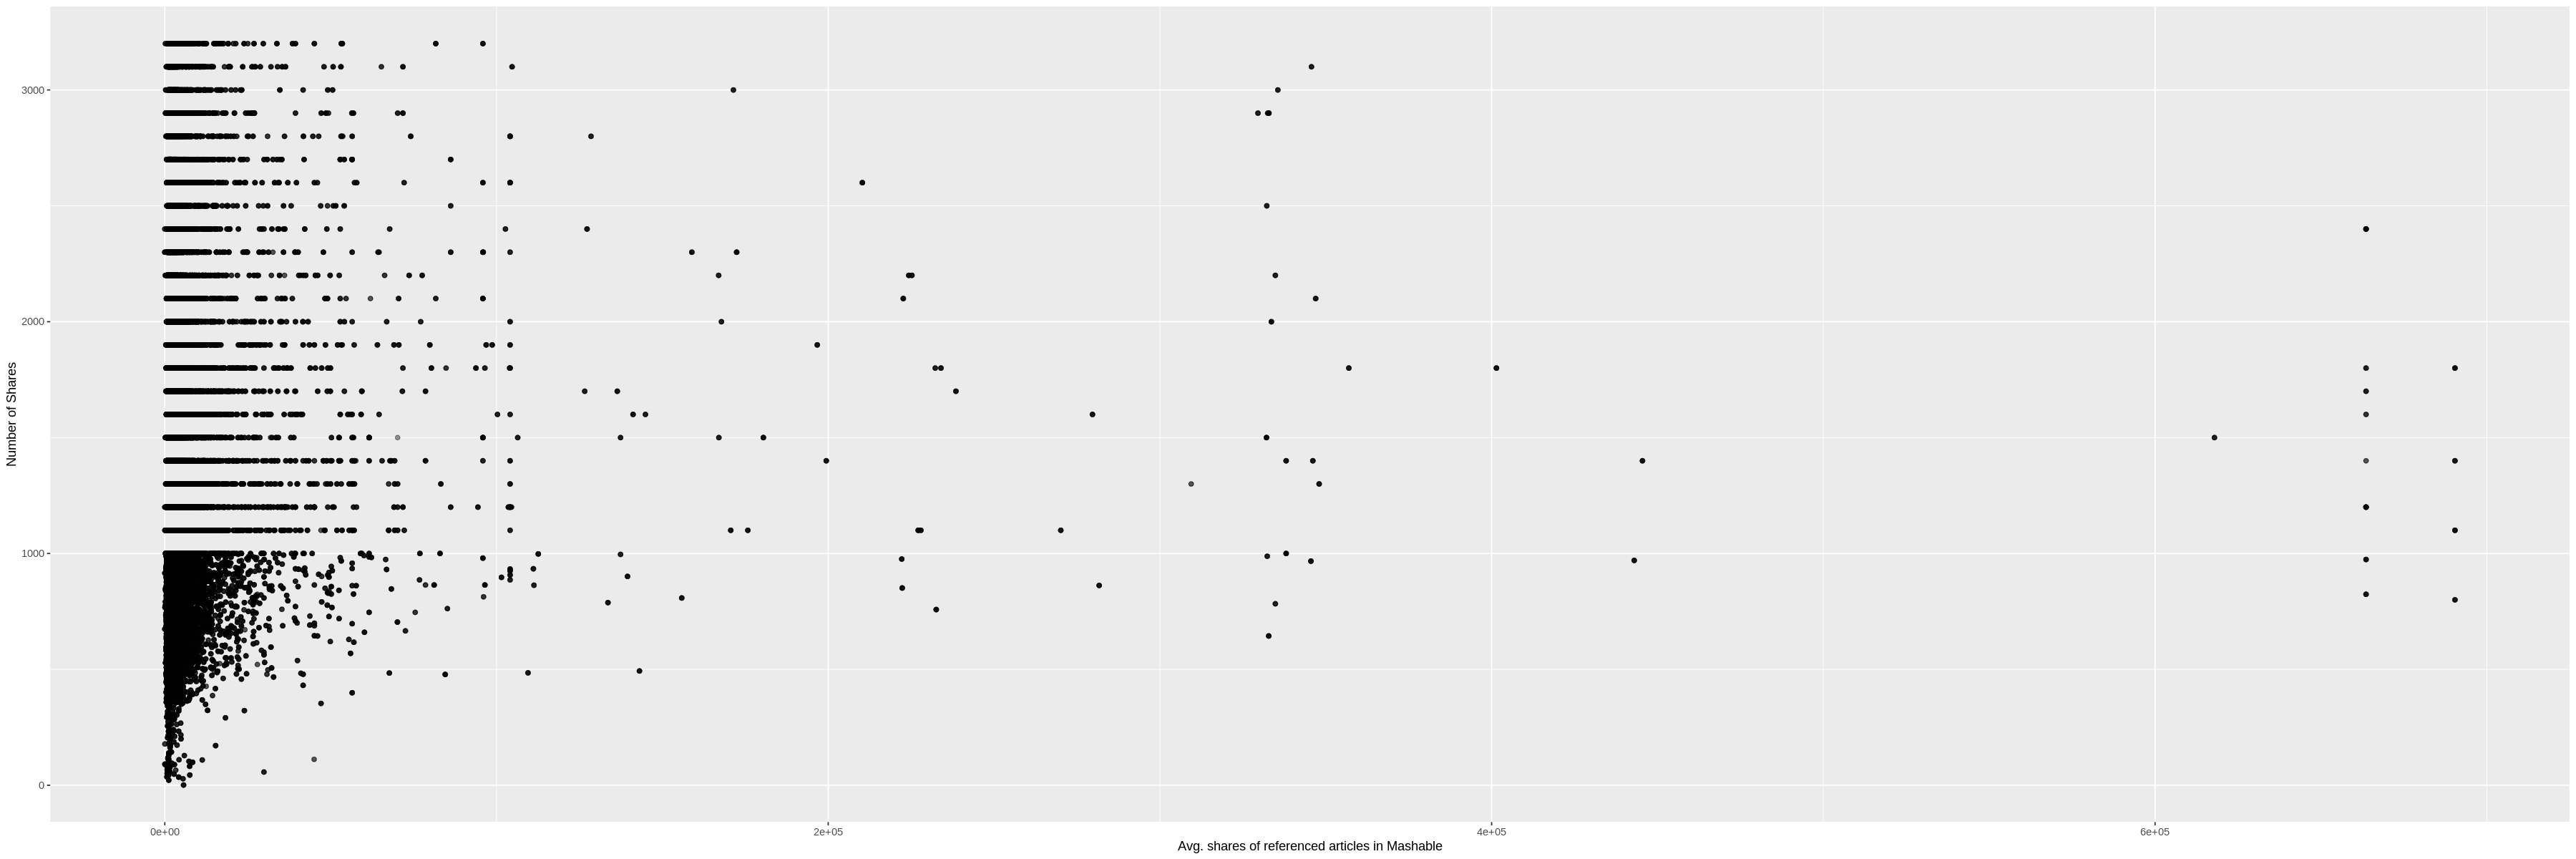

In [23]:
## Remove the outliers
eda_sf_rm_outl <- tran_predictors %>% 
                  filter(popularity != "Viral") %>%
                  # filter(self_reference_avg_sharess < 2e+05) %>%
                  ggplot(aes(x = self_reference_avg_sharess, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Avg. shares of referenced articles in Mashable") +
                  ylab("Number of Shares")
eda_sf_rm_outl

 the correlation is small, so it is unlikely we will see a linear pattern

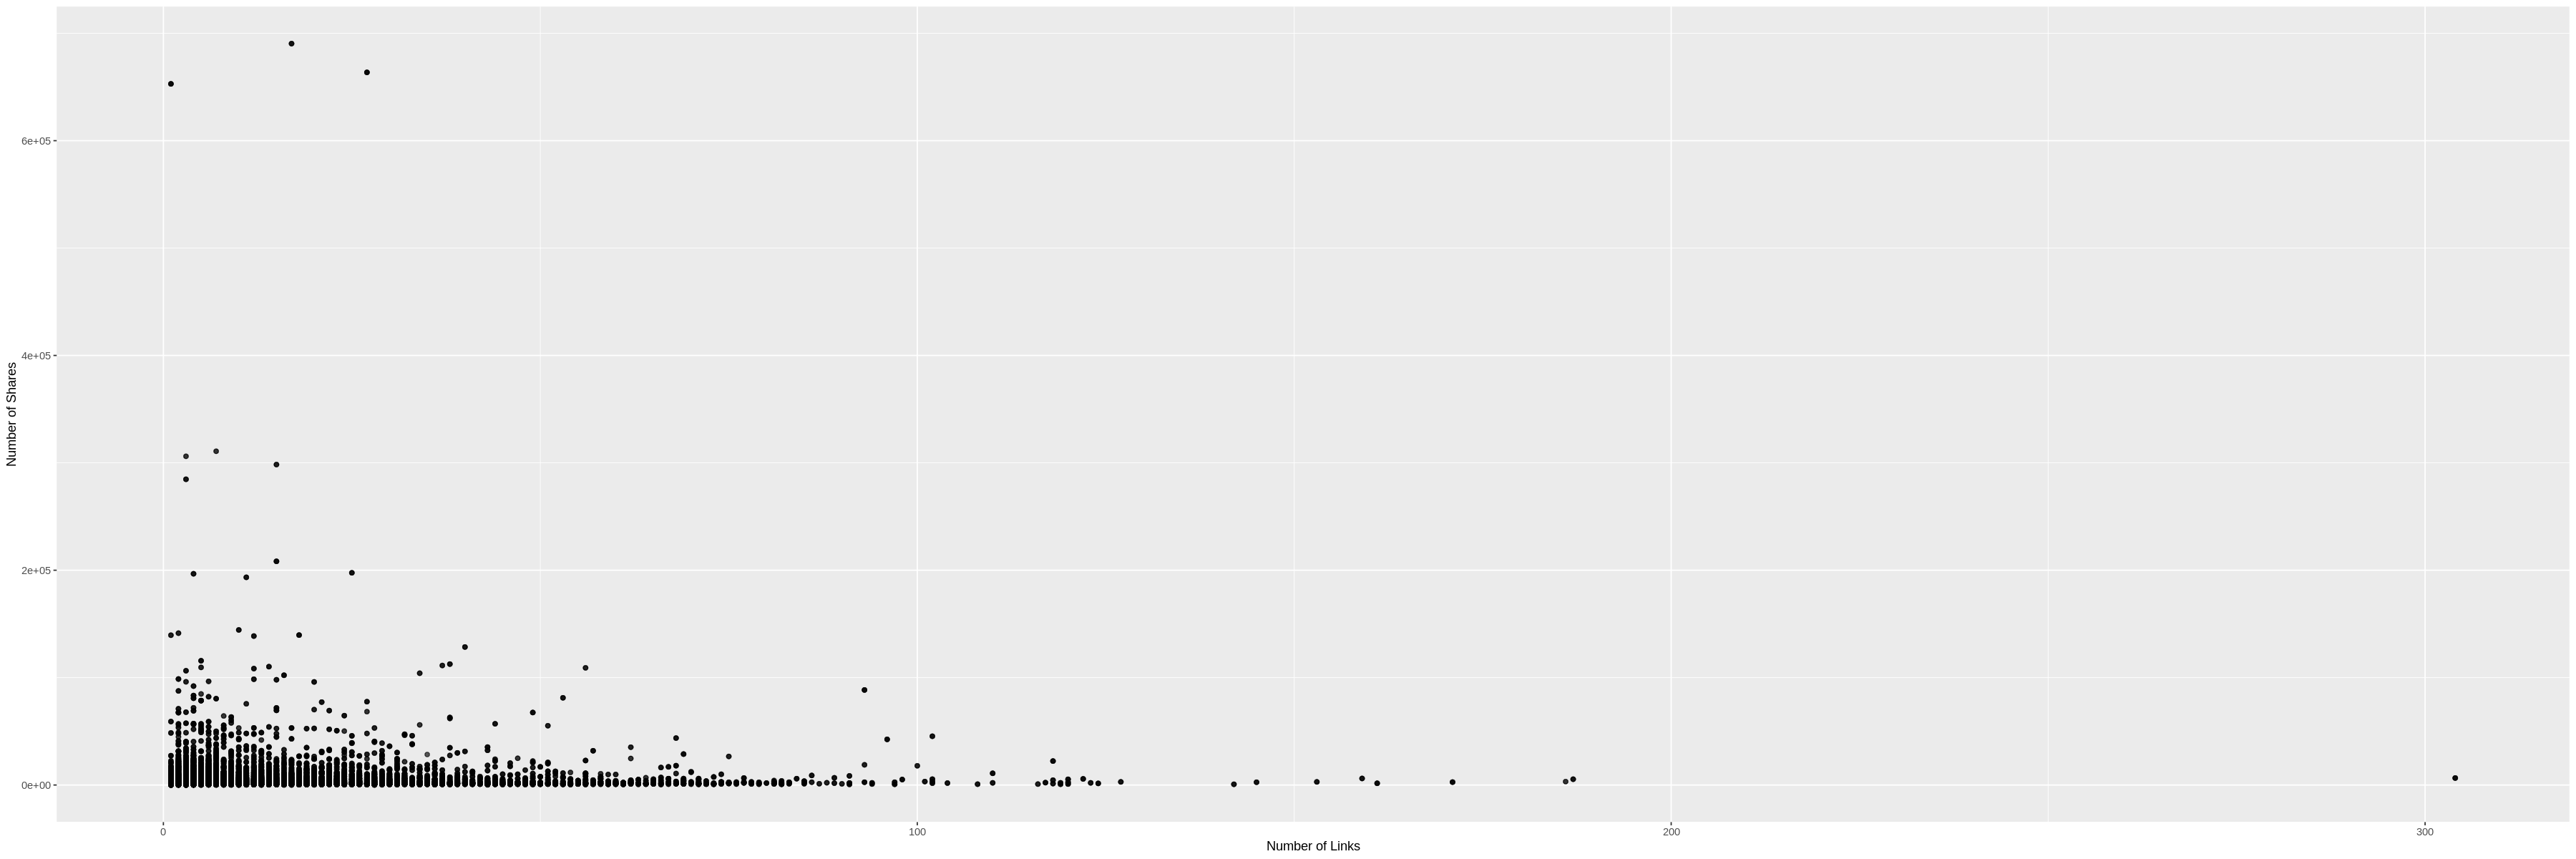

In [26]:
eda_ref_rm <- tran_predictors %>% 
                  ggplot(aes(x = num_hrefs, y = shares)) +
                  geom_point(alpha = 0.4) +
                  xlab("Number of Links") +
                  ylab("Number of Shares")
eda_ref_rm

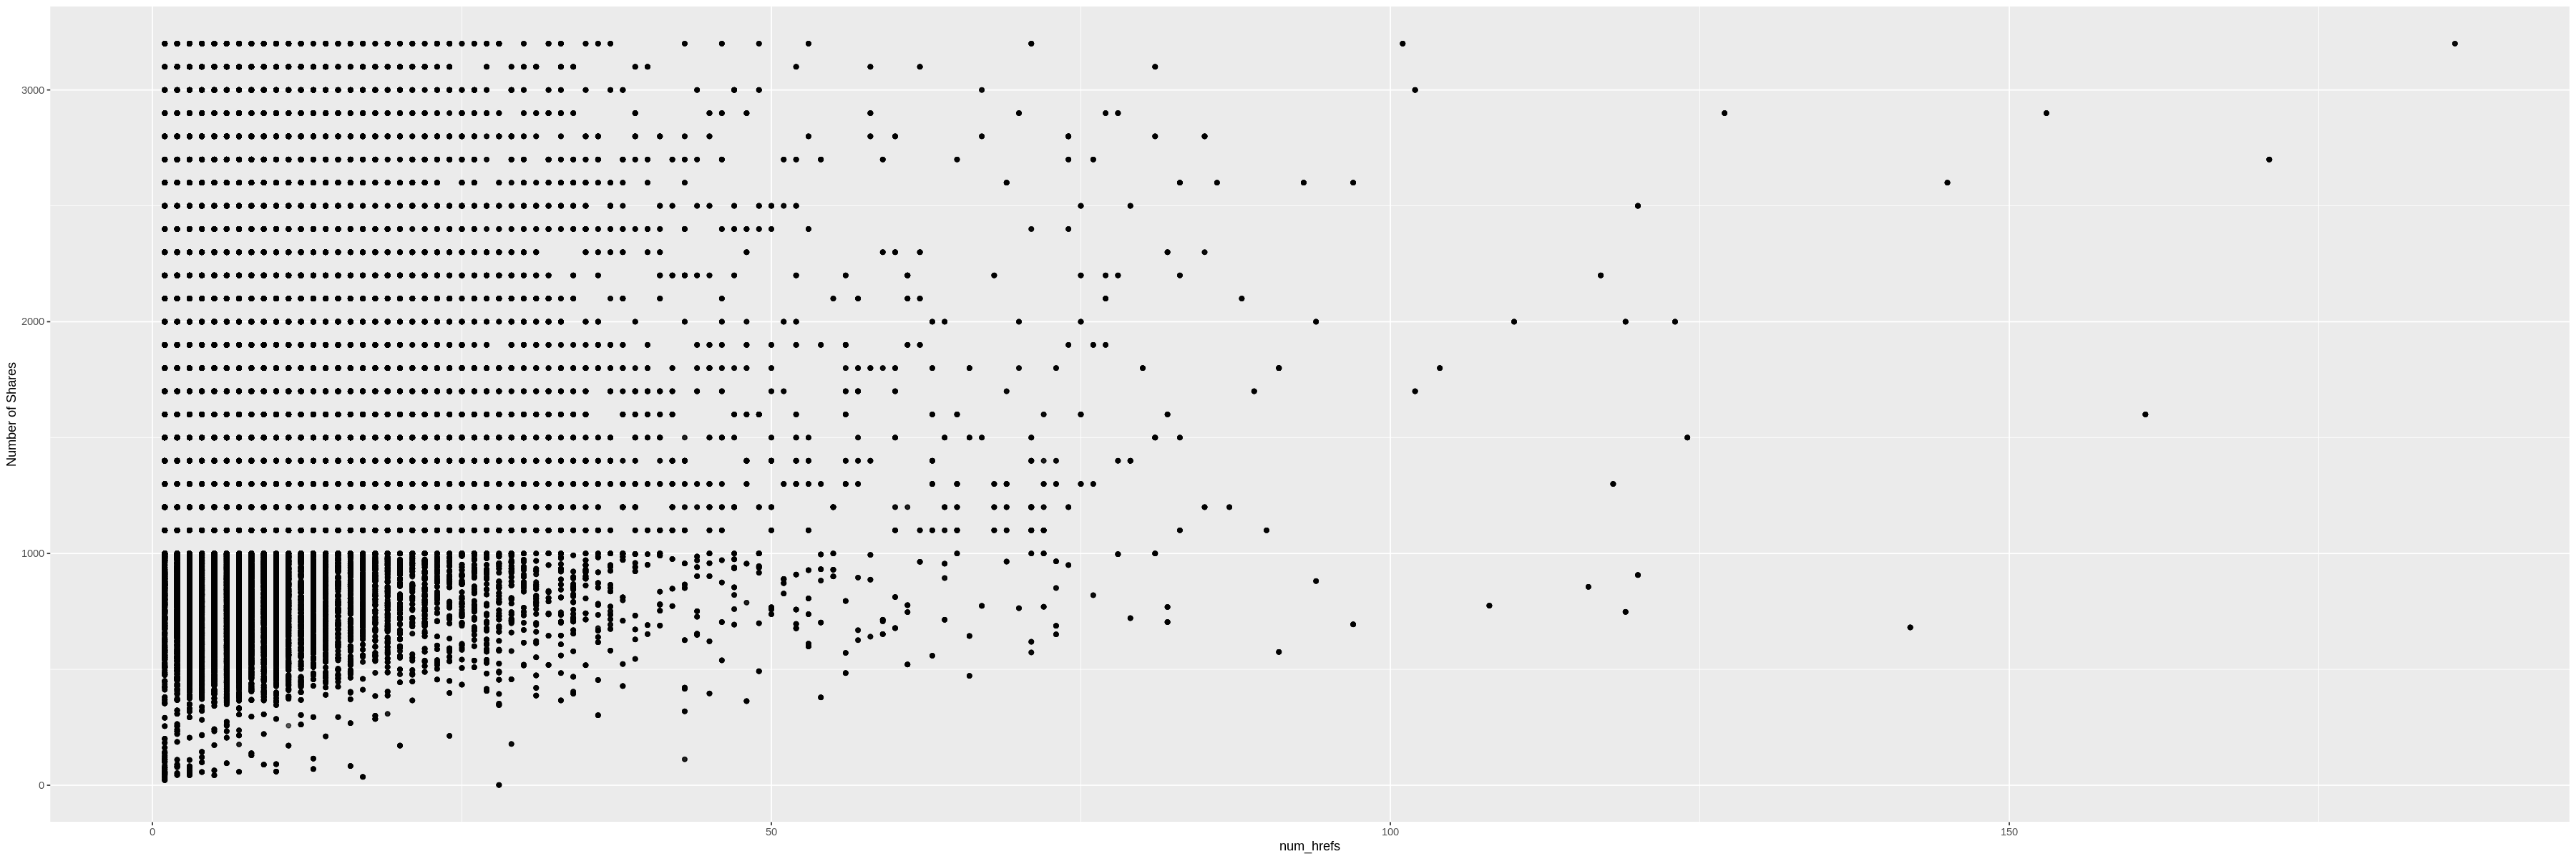

In [27]:
## Remove the outliers
eda_ref_rm_outl <- tran_predictors %>% 
                  filter(popularity != "Viral") %>%
                  # filter(self_reference_avg_sharess < 2e+05) %>%
                  ggplot(aes(x = num_hrefs, y = shares)) +
                  geom_point(alpha = 0.4) +
                  geom_point(alpha = 0.4) +
                  ylab("Number of Shares")
eda_ref_rm_outl

In [28]:
## the correlation is small, so it is unlikely we will see a linear pattern

A count of the observations in each popularity category

In [31]:
tran_predictors %>% group_by(popularity) %>% 
                    summarise(count = n())

`summarise()` ungrouping output (override with `.groups` argument)



popularity,count
<fct>,<int>
Not_Popular,2917
Popular,43875
Somewhat_Popular,60962
Viral,25197


Warning message:
“Removed 1486 rows containing non-finite values (stat_boxplot).”


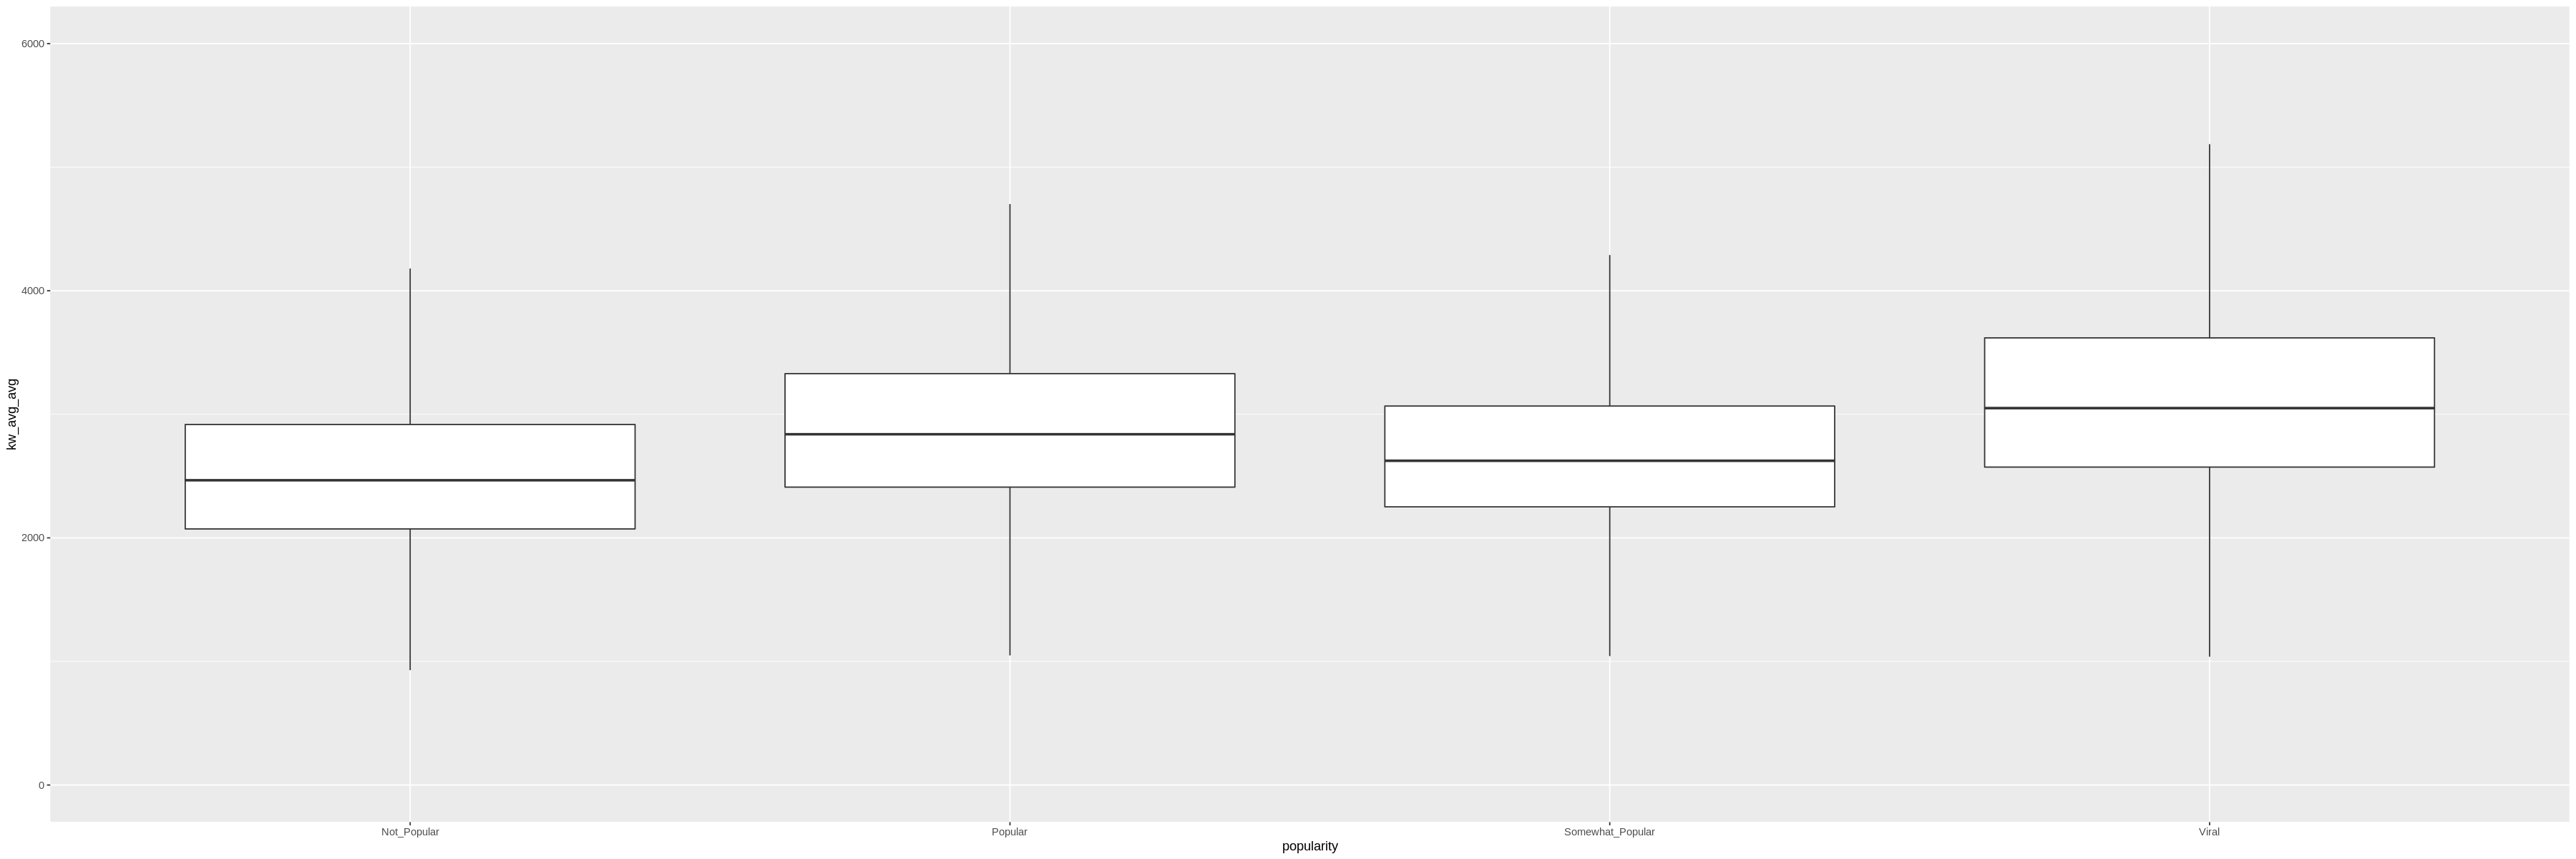

In [32]:
ggplot(tran_predictors, aes(x = popularity, y = kw_avg_avg)) +
geom_boxplot(outlier.shape = NA) +
   ylim(0, 6000)


Warning message:
“Removed 30654 rows containing non-finite values (stat_boxplot).”


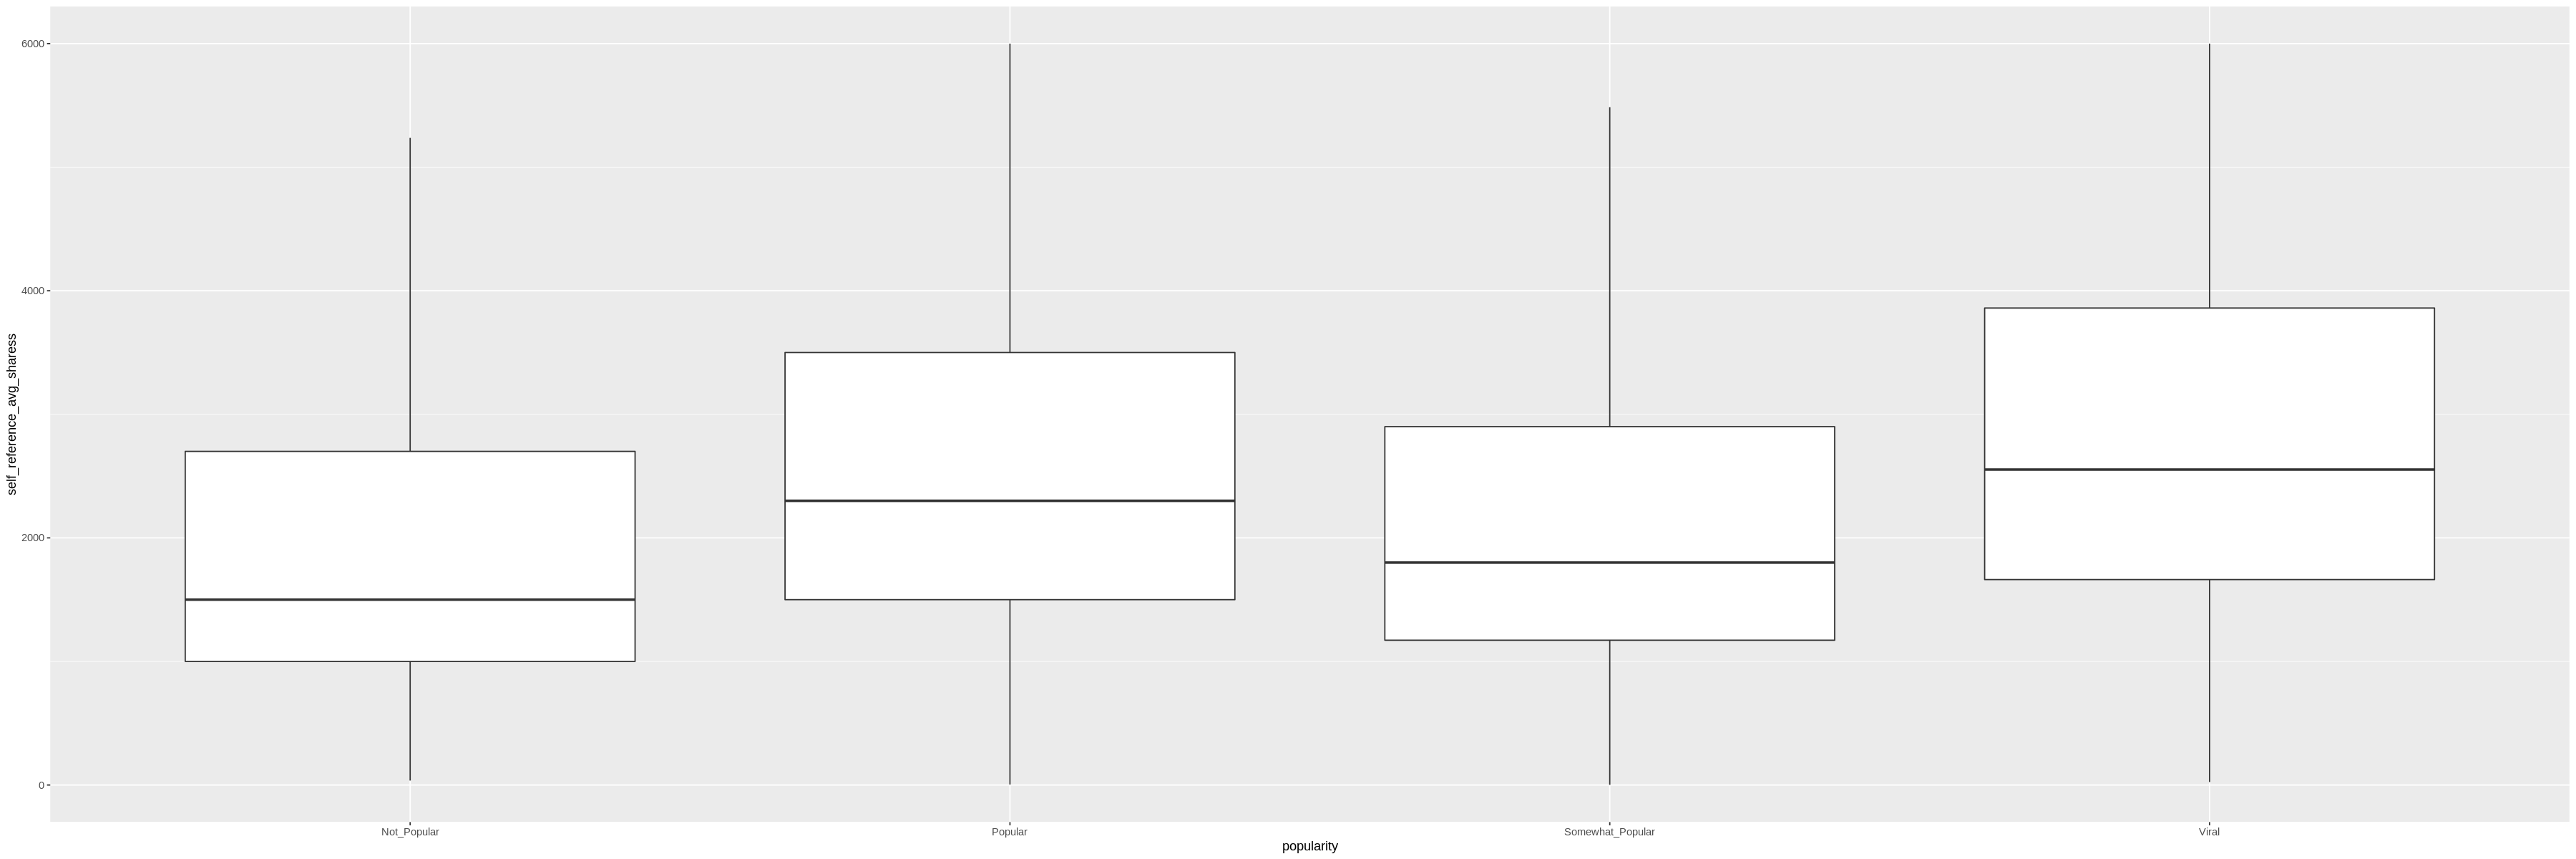

In [33]:
ggplot(tran_predictors, aes(x = popularity, y = self_reference_avg_sharess)) +
geom_boxplot(outlier.shape = NA) +
   ylim(0, 6000)


Warning message:
“Removed 6553 rows containing non-finite values (stat_boxplot).”


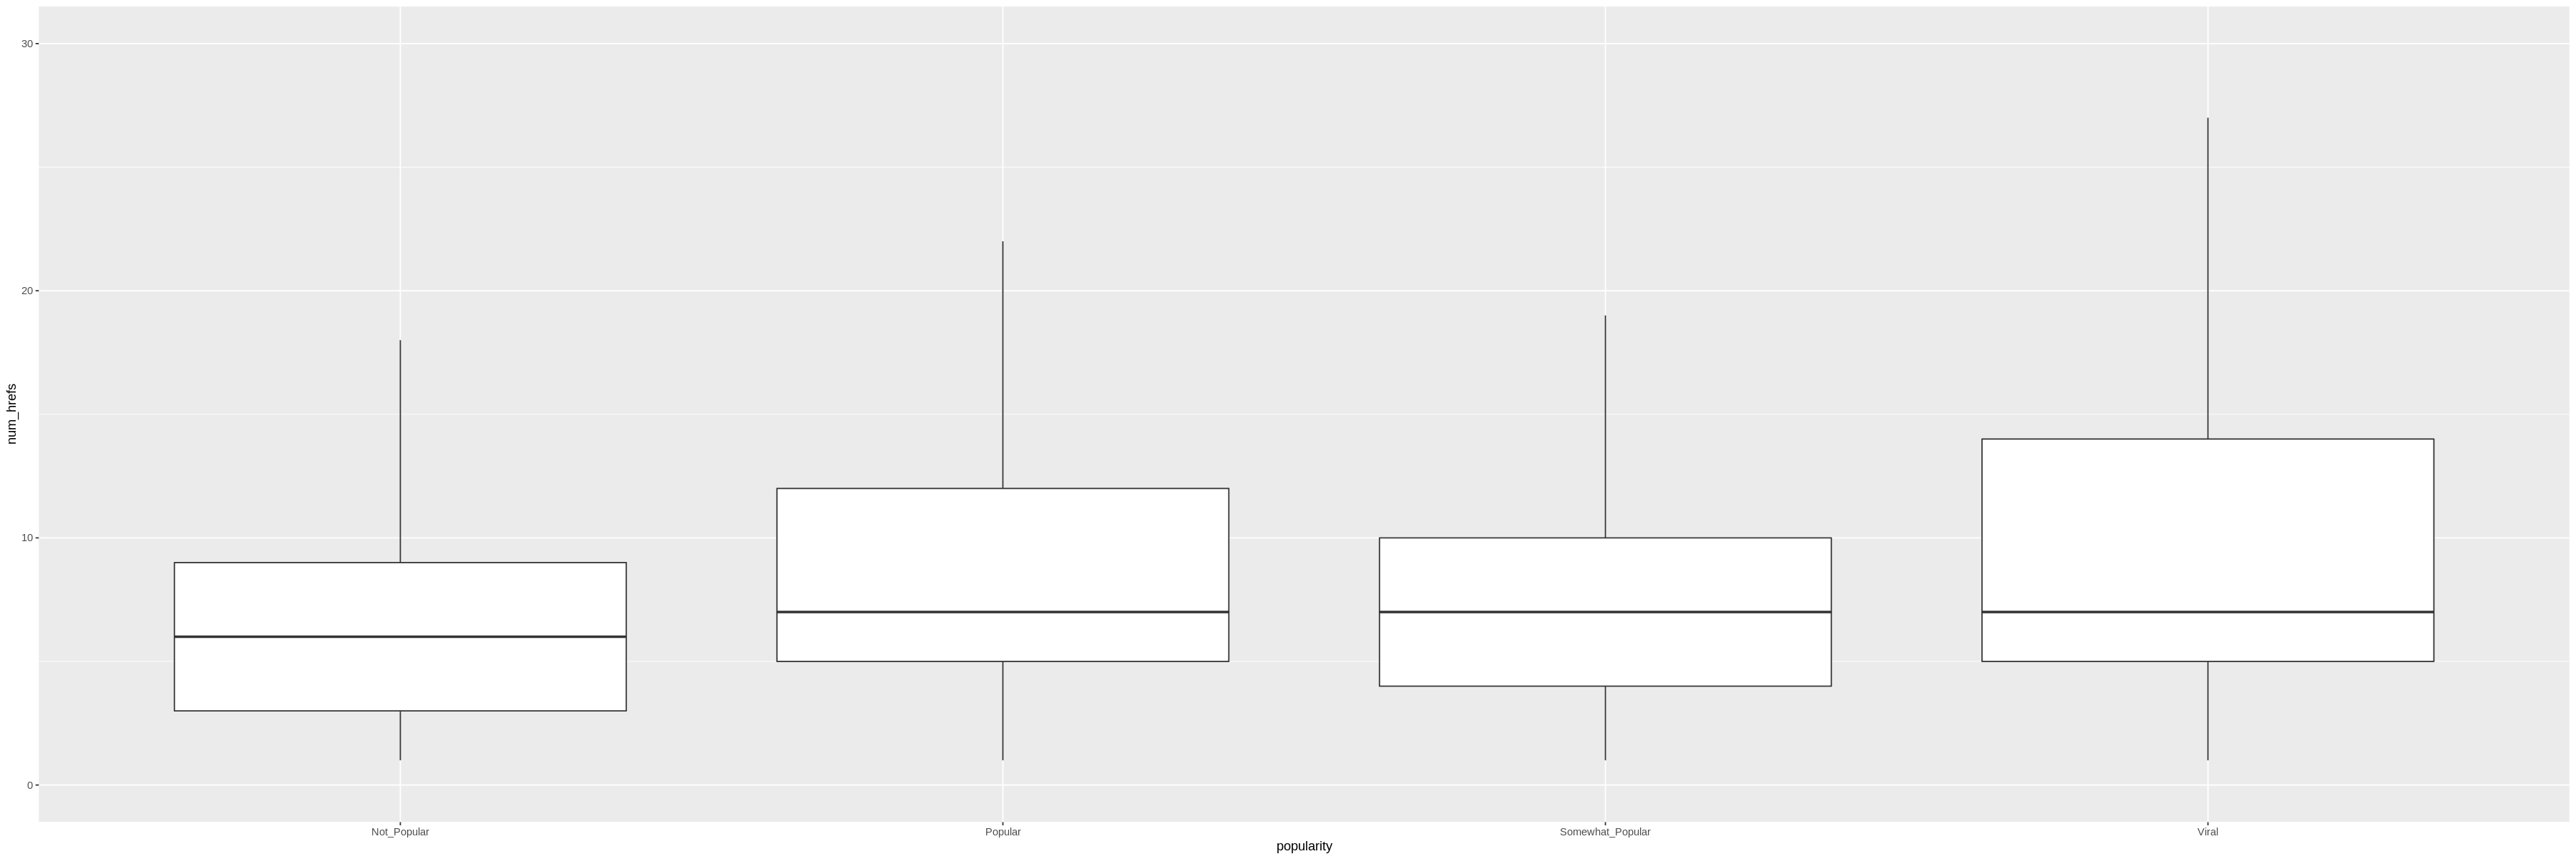

In [34]:
ggplot(tran_predictors, aes(x = popularity, y = num_hrefs)) +
geom_boxplot(outlier.shape = NA) +
   ylim(0, 30)

#### Methods

Like we mentioned in the preliminary exploratory, we cleaned the data 17 columns out of 61, which are about shared numbers, when the articles were published (Monday to Sunday), category of the articles (Lifestyle, Entertainment etc.), rate of unique words, average length, and both best and worst keywords. Those columns were thought to be connected with a shared number. Also, using the 4 categories about popularity we defined above, we separate the data and cut out outliers, and we use box plots and histogram to visualize.

#### Expected outcomes and significance

We expect to find some kind of relationship between the columns of the dataset and the popularity. Also, considering the amount of columns we already have in the dataset, it would not be a surprise if the relationship is not easily visible to human visualization. Such a relationship will however be examined on how well it can predict the popularity of a new observation. Such findings can help us understand what are some properties of news articles that make them popular. It can lead to further questions such as which column have more profound impact on popularity? Or do the columns responsible for popularity different for different types of topics?